In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import optuna.integration.lightgbm as lgb

from sklearn.metrics import accuracy_score # 正解率
from sklearn.metrics import precision_score # 適合率
from sklearn.metrics import recall_score # 再現率
from sklearn.metrics import f1_score # f1_score

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
display(train.head(3))
display(train.tail(3))
display(train.shape)
display(train.dtypes)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0


,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
847,50,Male,0.826785,0.138898,230.340081,40.495102,49.620857,7.529840,3.724408,0.987033,1
848,32,Female,0.761972,0.137969,214.170393,18.048321,54.447774,5.944855,3.150978,1.220787,0
849,64,Male,0.762713,0.218435,214.720510,15.885571,24.789606,6.768439,3.686097,1.309895,0


(850, 11)

Age           int64
Gender       object
T_Bil       float64
D_Bil       float64
ALP         float64
ALT_GPT     float64
AST_GOT     float64
TP          float64
Alb         float64
AG_ratio    float64
disease       int64
dtype: object

In [4]:
display(test.head(3))
display(test.tail(3))
display(test.shape)
display(test.dtypes)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,25,Male,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006
1,26,Female,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562
2,64,Male,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579


,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
347,25,Male,0.787054,0.186129,214.167523,14.936585,20.589993,7.505128,3.619033,1.287256
348,64,Male,0.725194,0.191307,220.272862,17.532595,48.115014,7.559414,3.635871,1.263348
349,57,Male,0.869632,0.236444,367.364415,23.534291,48.729618,7.537565,3.629533,1.285716


(350, 10)

Age           int64
Gender       object
T_Bil       float64
D_Bil       float64
ALP         float64
ALT_GPT     float64
AST_GOT     float64
TP          float64
Alb         float64
AG_ratio    float64
dtype: object

0	id	int	インデックスとして使用  
1	Age	int	年齢  
2	Gender	char	性別  
3	T_Bil	float	検査項目1： 総ビリルビン (Total Bilirubin)  
4	D_Bil	float	検査項目2： 直接ビリルビン (Direct Bilirubin)  
5	ALP	float	検査項目3： アルカリフォスファター ゼ (Alkaline Phosphotase)  
6	ALT_GPT	float	検査項目4： アラニンアミノトランスフェラーゼ (Alanine Transaminase)  
7	AST_GOT	float	検査項目5： アスパラギン酸アミノトランスフェラーゼ (Aspartate Aminotransferase)  
8	TP	float	検査項目6： 総タンパク (Total Protiens)  
9	Alb	float	検査項目7： アルブミン (Albumin)  
10	AG_ratio	float	検査項目8： アルブミン/グロブリン比  
11	disease	int	肝疾患の有無（0:無, 1:有）  

In [5]:
# 相関係数
train.corr()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
Age,1.000000,-0.001248,-0.014136,-0.023907,-0.037906,-0.008589,-0.037754,-0.087120,-0.033220,0.024216
T_Bil,-0.001248,1.000000,0.753227,0.148064,0.219784,0.248709,-0.060230,-0.162017,-0.206122,0.357653
D_Bil,-0.014136,0.753227,1.000000,0.091924,0.184403,0.201485,0.017750,-0.089132,-0.121481,0.282316
ALP,-0.023907,0.148064,0.091924,1.000000,-0.021187,0.019047,0.025728,-0.023041,-0.159614,0.211950
ALT_GPT,-0.037906,0.219784,0.184403,-0.021187,1.000000,0.655518,-0.100572,-0.087652,0.005806,0.199239
AST_GOT,-0.008589,0.248709,0.201485,0.019047,0.655518,1.000000,-0.071592,-0.086669,-0.022277,0.316456
TP,-0.037754,-0.060230,0.017750,0.025728,-0.100572,-0.071592,1.000000,0.727319,0.270246,-0.073766
Alb,-0.087120,-0.162017,-0.089132,-0.023041,-0.087652,-0.086669,0.727319,1.000000,0.607400,-0.176602
AG_ratio,-0.033220,-0.206122,-0.121481,-0.159614,0.005806,-0.022277,0.270246,0.607400,1.000000,-0.307895
disease,0.024216,0.357653,0.282316,0.211950,0.199239,0.316456,-0.073766,-0.176602,-0.307895,1.000000


<AxesSubplot:>

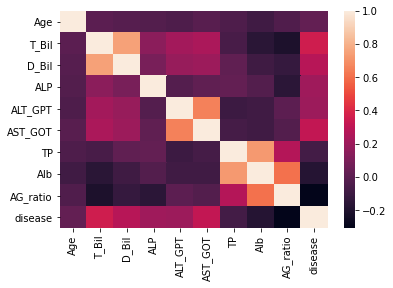

In [6]:
sns.heatmap(train.corr())

### 外れ値処理

In [7]:
num_list = list(test.select_dtypes(exclude=object).columns[:9])
num_list

['Age', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb', 'AG_ratio']

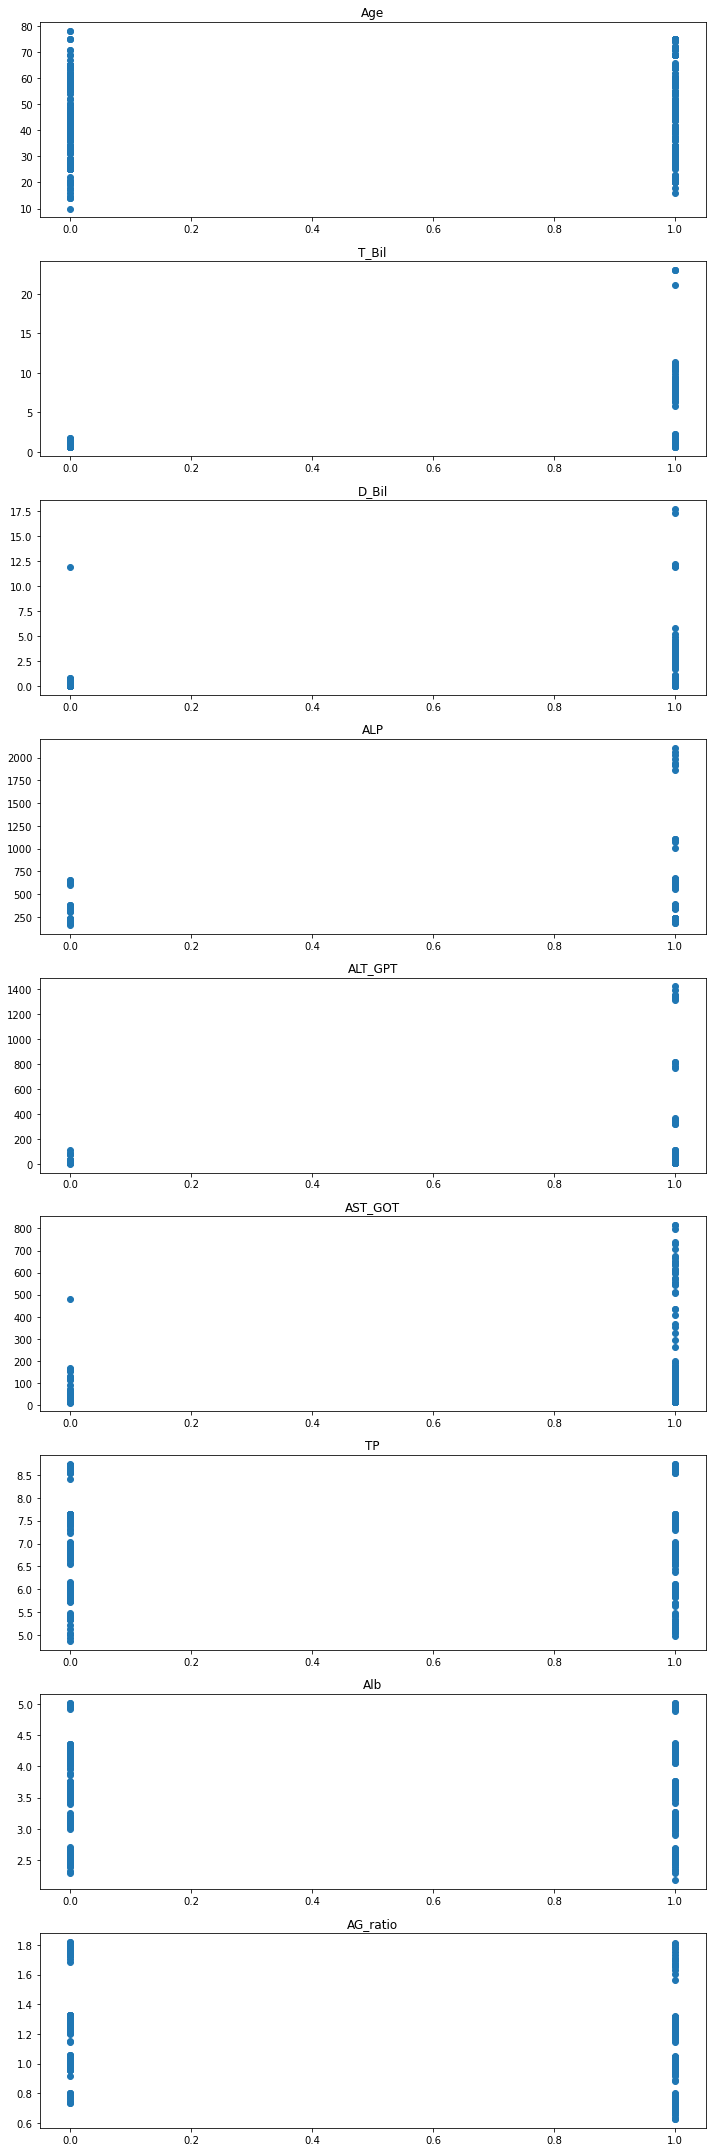

In [8]:
# diseaseごとの各カラムの散布図を見て外れ値を探す

fig = plt.figure(figsize=(10,30))

for i in range(len(num_list)):
    plt.subplot(9, 1, i+1)
    plt.title(num_list[i])
    plt.scatter(train['disease'], train[num_list[i]])

plt.tight_layout()

In [9]:
# Age 削除対象
display(train[(train['Age']>75) & (train['disease']==0)])
display(train[(train['Age']<12) & (train['disease']==0)])

train = train.drop(train[(train['Age']>75) & (train['disease']==0)].index)
train = train.drop(train[(train['Age']<12) & (train['disease']==0)].index)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
268,78,Male,0.810486,0.197167,213.961347,15.247348,20.931720,7.530853,3.634814,1.285051,0
475,78,Male,0.717658,0.164531,207.302298,9.473956,21.145924,6.864853,3.600574,1.311394,0


,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
402,10,Male,0.767137,0.173513,214.651243,13.132598,20.931029,7.536683,4.212869,1.288729,0


In [10]:
# T-Bil 削除対象
display(train[train['T_Bil']>15])

# 削除
train = train.drop(train[train['T_Bil']>15].index)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
69,26,Male,23.017027,11.992452,214.777736,12.921732,98.892019,7.595521,3.585702,0.987575,1
240,50,Female,21.184706,17.264120,214.413921,16.616958,28.436753,8.639342,3.089583,1.225404,1
297,32,Male,23.013928,17.692164,206.635298,10.197751,22.378512,5.844967,3.136777,1.184554,1
468,32,Male,23.002653,11.978404,1861.148040,23.111268,62.911839,6.882093,3.203098,0.913798,1


In [11]:
# D-Bil 削除対象
display(train[train['D_Bil']>10])

train = train.drop(train[train['D_Bil']>10].index)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
119,47,Male,0.874862,12.140346,212.041216,44.877908,104.234557,8.612374,3.520750,1.215675,1
130,42,Male,0.930668,11.935322,197.000997,10.514899,14.825766,7.581402,3.659571,1.024392,0
363,59,Male,0.972024,11.908908,217.020581,13.980081,59.748856,8.661666,3.663260,1.289892,1
766,65,Male,0.858532,12.033170,220.387128,17.155909,80.863658,7.629307,4.123316,1.184591,1
826,32,Male,0.983627,12.201824,218.317890,10.606974,75.159134,7.602828,3.685454,0.987741,1


In [12]:
# AST-GOT 削除対象
display(train[(train['AST_GOT']>400) & (train['disease']==0)])

train = train.drop(train[(train['AST_GOT']>400) & (train['disease']==0)].index)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
662,75,Male,1.465158,0.767795,366.834104,116.407037,481.935324,8.631458,4.337368,1.262153,0


### カテゴリデータの可視化

<AxesSubplot:title={'center':'train Gender'}, xlabel='Gender'>

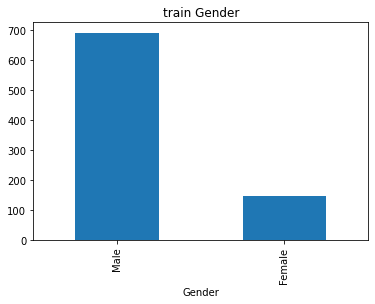

In [13]:
train.groupby("Gender")["Gender"].count().sort_values(ascending=False).plot(kind="bar", title="train Gender")

<AxesSubplot:title={'center':'test Gender'}, xlabel='Gender'>

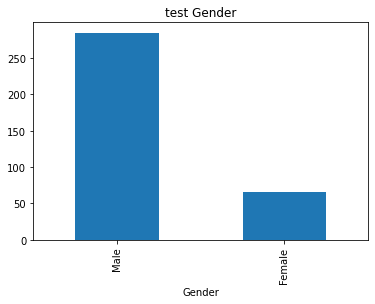

In [14]:
test.groupby("Gender")["Gender"].count().sort_values(ascending=False).plot(kind="bar", title="test Gender")

### 欠損値処理

In [15]:
display(train.isnull().sum())
display(test.isnull().sum())

Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    0
disease     0
dtype: int64

Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    0
dtype: int64

### ラベルエンコーディング

In [16]:
lbl = preprocessing.LabelEncoder()

In [17]:
train["Gender"] = lbl.fit_transform(train["Gender"])
test["Gender"] = lbl.fit_transform(test["Gender"])

### 特徴量選択

In [18]:
features = ['Age', 'Gender', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb', 'AG_ratio']

### Filter Method

In [19]:
train.corr()["disease"]

Age         0.030424
Gender      0.107368
T_Bil       0.390404
D_Bil       0.384449
ALP         0.213185
ALT_GPT     0.202359
AST_GOT     0.324016
TP         -0.079806
Alb        -0.174934
AG_ratio   -0.308226
disease     1.000000
Name: disease, dtype: float64

In [20]:
# D_Bil	T_Bil 0.930493

# disease T_Bil 0.390951
# disease D_Bil 0.384931 -> こちらを削除
train.corr()[abs(train.corr()) > 0.8]

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
Age,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T_Bil,NaN,NaN,1.000000,0.930462,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D_Bil,NaN,NaN,0.930462,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALP,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
ALT_GPT,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
AST_GOT,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
TP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Alb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
AG_ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [21]:
features = ['Age', 'Gender', 'T_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb', 'AG_ratio']

### 年代別のデータの分割

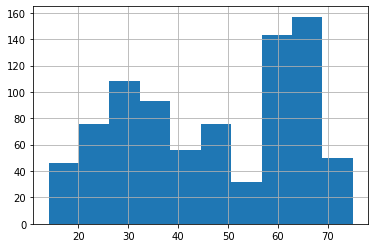

In [22]:
train['Age'].hist()
plt.show()

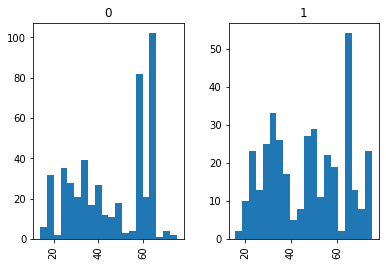

In [23]:
train['Age'].hist(by=train['disease'], bins=20)
plt.show()

In [24]:
split_list = [0, 50, 100]
label_split = []

In [25]:
for i in range(len(split_list)-1):
    label_split.append(str(split_list[i]) + "_" + str(split_list[i+1]))

In [26]:
label_split

['0_50', '50_100']

In [27]:
train["Age_cls"] = pd.cut(train['Age'], split_list, labels=label_split)
test["Age_cls"] = pd.cut(test['Age'], split_list, labels=label_split)

In [28]:
test.groupby("Age_cls").count()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
Age_cls,,,,,,,,,,
0_50,196,196,196,196,196,196,196,196,196,196
50_100,154,154,154,154,154,154,154,154,154,154


In [29]:
for i in range(2):
    print(test[test["Gender"]==i].groupby("Age_cls").count()["Age"])

Age_cls
0_50      41
50_100    24
Name: Age, dtype: int64
Age_cls
0_50      155
50_100    130
Name: Age, dtype: int64


### データの分割

In [30]:
# testデータに復元用のNo.を振る
serial_num = pd.RangeIndex(start=1, stop=test.shape[0]+1, step=1)
test['No'] = serial_num

In [31]:
params = {
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'objective': 'binary',
    'verbosity': -1,
    'seed': 42,
    'learning_rate': 0.1,
    'bagging_fraction': 0.75,
    'bagging_freq': 10, 
    'colsample_bytree': 0.75,
}

### 年代別区分

In [32]:
test_pred = train.head(0)
test_pred

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,Age_cls


In [33]:
vali_list = {}

In [34]:
# 年代別に学習
# 性別も追加
    
for i in label_split:
    train_tmp = train[train["Age_cls"]==i]
    test_tmp = test[test["Age_cls"]==i]
    
    # ホールドアウト法
    X_train, X_test, y_train, y_test = train_test_split(train_tmp[features], 
                                                        train_tmp["disease"], test_size=0.3, random_state=42)

    # lightGBM用のデータセット作成
    train_set = lgb.Dataset(X_train, y_train)
    val_set = lgb.Dataset(X_test, y_test, reference=train_set)
    
    # 学習
    model_lgb = lgb.train(params, train_set, valid_sets=val_set,
                    verbose_eval=None,  # 50イテレーション毎に学習結果出力
                    num_boost_round=100,  # 最大イテレーション回数指定
                    early_stopping_rounds=100
                    )
    
    # 評価
    val_prob = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)
    val_pred = np.round(val_prob)
    
    # 誤差
    print(f"{i}歳代")
    print(f"正解率: {accuracy_score(y_test, val_pred)}")
    print(f"適合率: {precision_score(y_test, val_pred)}")
    print(f"再現率: {recall_score(y_test, val_pred)}")
    print(f"f1_score: {f1_score(y_test, val_pred)}\n")
    
    vali_list.update([(i, f1_score(y_test, val_pred))])
    
    # 予測データ作成
    y_prob = model_lgb.predict(test_tmp[features], num_iteration=model_lgb.best_iteration)
    y_pred = np.round(y_prob)
    
    test_tmp["disease"] = y_pred
    test_pred = pd.concat([test_pred, test_tmp]).sort_values('No')

min_data_in_leaf, val_score: 0.891134: 100%|##########| 5/5 [00:00<00:00,  6.82it/s]


0_50歳代
正解率: 0.8102189781021898
適合率: 0.7538461538461538
再現率: 0.8305084745762712
f1_score: 0.7903225806451613



min_data_in_leaf, val_score: 0.987083: 100%|##########| 5/5 [00:00<00:00,  6.45it/s]


50_100歳代
正解率: 0.9217391304347826
適合率: 0.8936170212765957
再現率: 0.9130434782608695
f1_score: 0.9032258064516129



In [35]:
vali_list

{'0_50': 0.7903225806451613, '50_100': 0.9032258064516129}

### データ出力

In [36]:
ss = pd.read_csv('sample_submit.csv', header=None)

In [37]:
ss[1] = test_pred["disease"]
ss.to_csv("lgb_Age_Sep_submission.csv", index=0, header=None)

### 年代と性別で区分

In [38]:
test_pred = train.head(0)
test_pred

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,Age_cls


In [39]:
vali_list = {}

In [41]:
# 年代別に学習
# 性別
for i in range(2):

    for j in label_split:
        train_tmp = train[train["Gender"]==i]
        test_tmp = test[test["Gender"]==i]

        train_tmp = train_tmp[train_tmp["Age_cls"]==j]
        test_tmp = test_tmp[test_tmp["Age_cls"]==j]
    
        # ホールドアウト法
        X_train, X_test, y_train, y_test = train_test_split(train_tmp[features],
                                                            train_tmp["disease"], train_size=0.7, test_size=0.3, random_state=42)

        # lightGBM用のデータセット作成
        train_set = lgb.Dataset(X_train, y_train)
        val_set = lgb.Dataset(X_test, y_test, reference=train_set)
    
        # 学習
        model_lgb = lgb.train(params, train_set, valid_sets=val_set,
                      verbose_eval=None,  # 50イテレーション毎に学習結果出力
                      num_boost_round=100,  # 最大イテレーション回数指定
                      early_stopping_rounds=100
                     )
    
        # 評価
        val_prob = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)
        val_pred = np.round(val_prob)
    
        # 誤差
        print(f"性別{i}、{j}歳代")
        print(f"正解率: {accuracy_score(y_test, val_pred)}")
        print(f"適合率: {precision_score(y_test, val_pred)}")
        print(f"再現率: {recall_score(y_test, val_pred)}")
        print(f"f1_score: {f1_score(y_test, val_pred)}\n")
    
        vali_list.update([(str(i)+" "+j, f1_score(y_test, val_pred))])
    
        # 予測データ作成
        y_prob = model_lgb.predict(test_tmp[features], num_iteration=model_lgb.best_iteration)
        y_pred = np.round(y_prob)
    
        test_tmp["disease"] = y_pred
        test_pred = pd.concat([test_pred, test_tmp]).sort_values('No')

min_data_in_leaf, val_score: 0.745455: 100%|##########| 5/5 [00:00<00:00,  7.97it/s]


性別0、0_50歳代
正解率: 0.625
適合率: 0.25
再現率: 0.1
f1_score: 0.14285714285714288



min_data_in_leaf, val_score: 0.500000: 100%|##########| 5/5 [00:00<00:00,  8.45it/s]


性別0、50_100歳代
正解率: 0.6923076923076923
適合率: 0.0
再現率: 0.0
f1_score: 0.0



min_data_in_leaf, val_score: 0.922714: 100%|##########| 5/5 [00:00<00:00,  7.03it/s]


性別1、0_50歳代
正解率: 0.8380952380952381
適合率: 0.8461538461538461
再現率: 0.8301886792452831
f1_score: 0.8380952380952382



min_data_in_leaf, val_score: 0.955894: 100%|##########| 5/5 [00:00<00:00,  7.62it/s]


性別1、50_100歳代
正解率: 0.883495145631068
適合率: 0.875
再現率: 0.8333333333333334
f1_score: 0.8536585365853658



In [42]:
vali_list

{'00_50': 0.14285714285714288,
 '050_100': 0.0,
 '10_50': 0.8380952380952382,
 '150_100': 0.8536585365853658}

In [43]:
ss = pd.read_csv('sample_submit.csv', header=None)

In [44]:
ss[1] = test_pred["disease"]
ss.to_csv("lgb_Age_Gen_Sep_submission.csv", index=0, header=None)